## RGB ISODATA Clustering

### Pre-processing and RGB generation

- Operates on sigma nought images
- Uses VV, VH, and VH/VV as the RGB channels.

1) Crop VV and VH to AOI

2) Convert VV and VH from linear to dB scale; handle log of zero
$$A = 10*\log_{10}(A)$$

3) Create ratio band VH/VV; handle divide by zero

4) Quantile clip (I have been clipping off the top 1% of values to reduce extreme outliers)

5) Map to the interval [0,1]. Can use

$$f(t)=c+\left( \frac{d-c}{b-a} \right) (t-a)$$

for mapping from $[a,b]$ to $[c,d]$ where $t$ is an input scalar, vector, matrix, or tensor

6) Assign RGB channels: red=VV, green=VH, blue=VH/VV

### ISODATA algorithm

- Unsupervised clustering algorithm
- Similar idea to k-means clustering
- Instead of giving a `k` number of clusters to produce, there are a lot of potential parameters...
- In my opinion, k-means may do an equally good job or better and is a lot simpler

Algorithm overview:
1) Initialize cluster centers

2) Assign pixels to clusters based off a distance metric to cluster center (L2 norm for me)

3) Optional: combine clusters or break apart clusters

4) Update cluster centers using assigned pixels (mean across RGB channels)

Some possible parameters (AKA the ones I have implemented right now):
- `random_init=False`: if true, initializes randomly off a uniform distribution ; if false, use existing pixels as centers
- `start_num=20`: number of clusters to start with
- `max_iter=10`: maximum number of iterations before exiting program
- `std_threshold=0.1`: split a cluster if its standard deviation is greater than this value
- `merge_threshold=0.1`: merge two clusters if the Euclidean distance between their centers is less than this value 

In [1]:
import os
os.chdir('../source')
from Cluster import Cluster
from Image import Image
import numpy as np
import matplotlib.pyplot as plt

vh_dir = '/data/csimmons/LA_vh/merged/SLC/20200106'
vv_dir = '/data/csimmons/LA_vv/merged/SLC/20200106'

In [2]:
VH_img = Image(vh_dir+'/geo_20200106.norm.ml.full.tif')
VV_img = Image(vv_dir+'/geo_20200106.norm.ml.full.tif')
VH_img.read()
VV_img.read()

geographic_bounds = [-118.7, -117.7, 33.5, 34.2]
# geographic_bounds = [-95.9, -95., 29.4, 29.7] # for Houston
cluster = Cluster(geographic_bounds)

In [3]:
rgb = cluster.construct_rgb_composite(VH_img, VV_img)

/home/csimmons/Research/SAR-Methods/source/Image.py:63: RuntimeWarning: divide by zero encountered in log10
  new_band = np.where(self.band != 0., 10.*np.log10(self.band), 0.)
/home/csimmons/Research/SAR-Methods/source/Cluster.py:32: RuntimeWarning: invalid value encountered in true_divide
  ratio_band = np.divide(VH.band, VV.band)


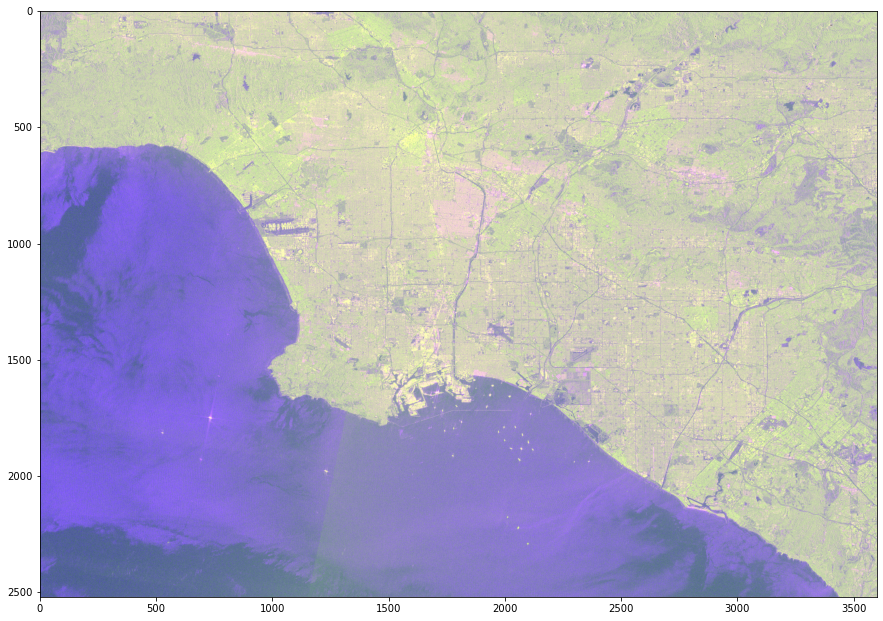

In [4]:
plt.figure(figsize=(15,15))
plt.imshow(rgb)
plt.show()

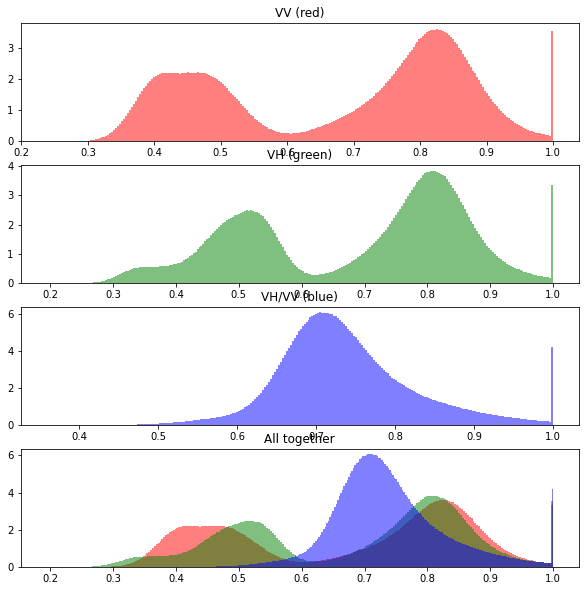

In [5]:
cluster.plot_rgb_histograms(rgb)

### Let's try ISODATA!

In [6]:
assignments = cluster.isodata(rgb)

Merging clusters 2 and 18 into cluster -1
Merging clusters 3 and 6 into cluster -2
Merging clusters 4 and 7 into cluster -3
Merging clusters 5 and 15 into cluster -4
Merging clusters 8 and 9 into cluster -5
Merging clusters 10 and 11 into cluster -6
Merging clusters 12 and 16 into cluster -7
Merging clusters 1 and 5 into cluster -1
Merging clusters 2 and 10 into cluster -1
Merging clusters 1 and 10 into cluster -1


In [7]:
np.unique(assignments)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

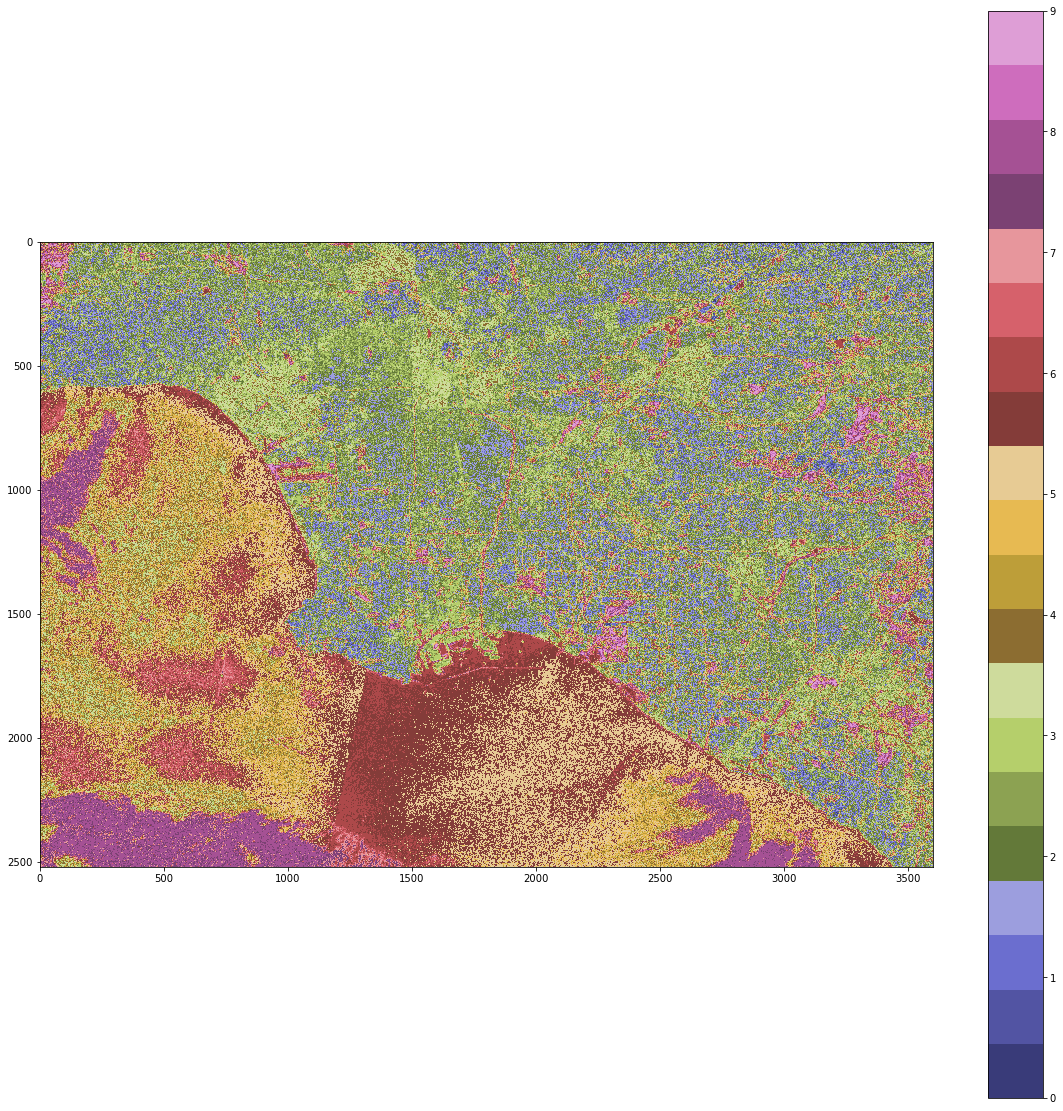

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(assignments, cmap='tab20b')
plt.colorbar()
plt.show()

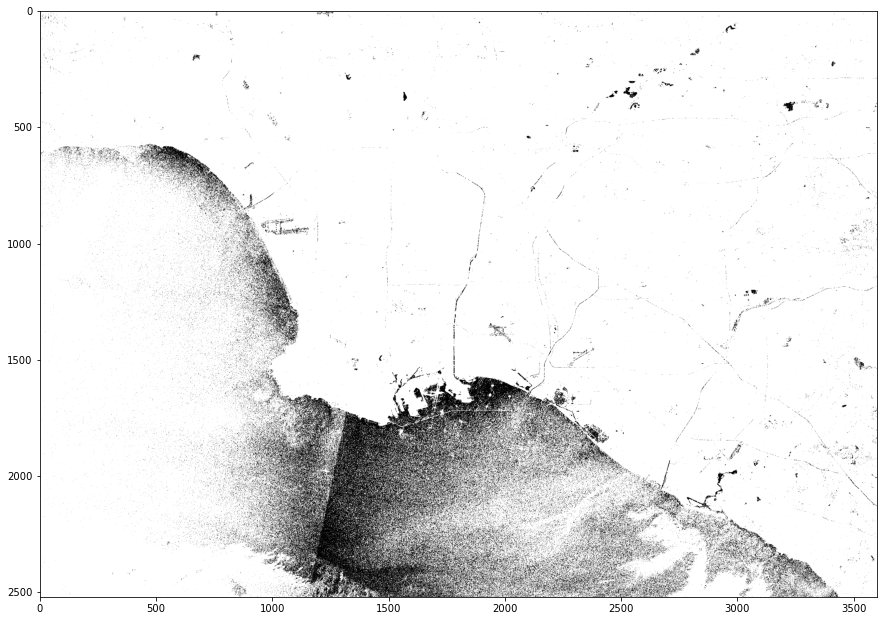

In [10]:
example = np.where(assignments == 6, 1, 0)
plt.figure(figsize=(15,15))
plt.imshow(example, cmap='binary')
plt.show()

Maybe this will improve with parameter tuning...

### Let's try k-means!

In [20]:
k_assignments = cluster.k_means(rgb, 4)

In [21]:
np.unique(k_assignments)

array([0, 1, 2, 3])

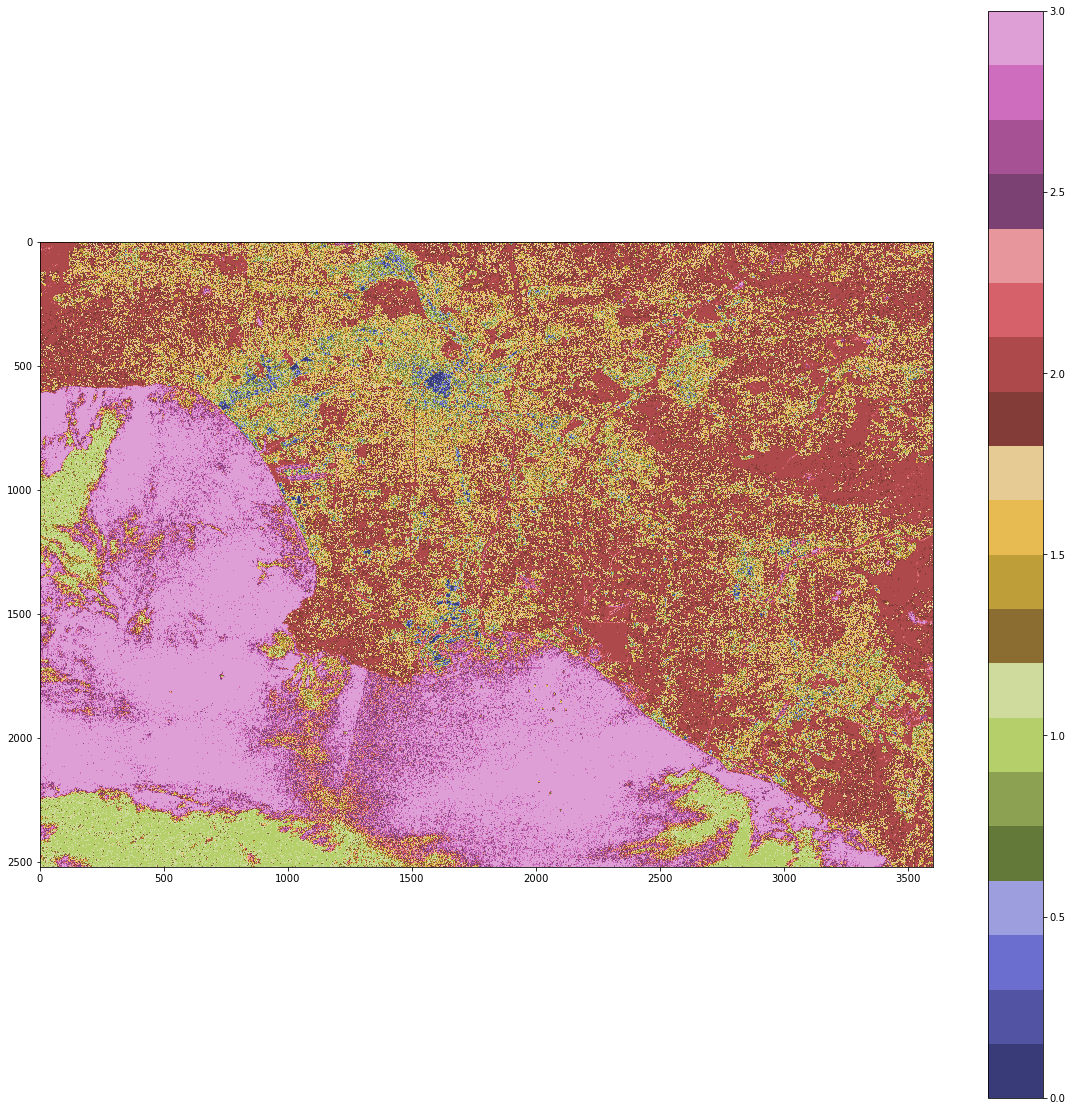

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(k_assignments, cmap='tab20b')
plt.colorbar()
plt.show()

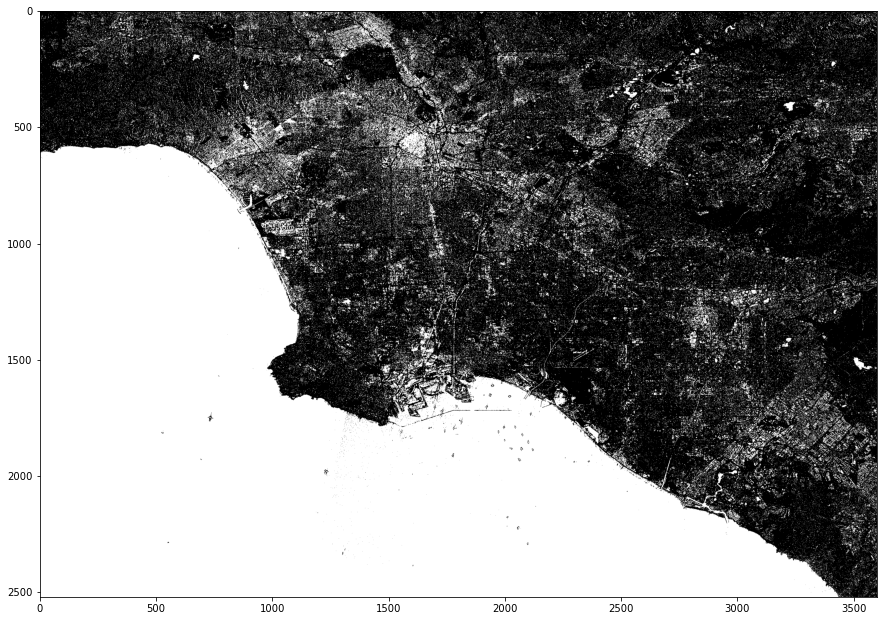

In [25]:
example2 = np.where(k_assignments == 2, 1, 0)
plt.figure(figsize=(15,15))
plt.imshow(example2, cmap='binary')
plt.show()

Hard to conclude what this means...

### Idea: cluster across a stack